In [3]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import pandas as pd
import arviz as az

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white', {'axes.linewidth': 0.5})
sns.set(style='white', font_scale=1.1,
        rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Verdana'],
            'text.latex.preamble': r"\usepackage{type1cm}"}) 
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

func_dict = {"mean": np.mean, "q2.5": lambda x: np.percentile(x, 2.5), "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results
!mkdir -p ../../figures/draft

In [4]:
from scipy.integrate import quad

class Integrate(theano.Op):
    def __init__(self, expr, var, *extra_vars):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = extra_vars
        self._func = theano.function(
            [var] + list(extra_vars),
            self._expr,
            on_unused_input='ignore')
    
    def make_node(self, start, stop, *extra_vars):
        self._extra_vars_node = extra_vars
        assert len(self._extra_vars) == len(extra_vars)
        self._start = start
        self._stop = stop
        vars = [start, stop] + list(extra_vars)
        return theano.Apply(self, vars, [tt.dscalar().type()])
    
    def perform(self, node, inputs, out):
        start, stop, *args = inputs
        val = quad(self._func, start, stop, args=tuple(args))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        start, stop, *args = inputs
        out, = grads
        replace = dict(zip(self._extra_vars, args))
        
        replace_ = replace.copy()
        replace_[self._var] = start
        dstart = out * theano.clone(-self._expr, replace=replace_)
        
        replace_ = replace.copy()
        replace_[self._var] = stop
        dstop = out * theano.clone(self._expr, replace=replace_)

        grads = tt.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, *self._extra_vars)
            darg = out * integrate(start, stop, *args)
            dargs.append(darg)
            
        return [dstart, dstop] + dargs

# Data

In [5]:
df = pd.read_csv("../../data/data.csv").reset_index().rename(columns={'index': 't'})
df['t'] = df['t'] + 1
display(df[:5])
df[-5:]

,t,date,time,reported,deaths,exports,prob_travel,prob_HN,popWuhan
0,1,2019-12-09,1,0,0,0,0.003566,0.000025,11081000
1,2,2019-12-10,2,0,0,0,0.003566,0.000025,11081000
2,3,2019-12-11,3,0,0,0,0.003566,0.000025,11081000
3,4,2019-12-12,4,0,0,0,0.003566,0.000025,11081000
4,5,2019-12-13,5,0,0,0,0.003566,0.000025,11081000


,t,date,time,reported,deaths,exports,prob_travel,prob_HN,popWuhan
42,43,2020-01-20,43,291,7,4,0.003566,0.000025,11081000
43,44,2020-01-21,44,440,18,6,0.003566,0.000025,11081000
44,45,2020-01-22,45,571,24,8,0.003566,0.000025,11081000
45,46,2020-01-23,46,830,34,11,0.003566,0.000025,11081000
46,47,2020-01-24,47,1118,41,20,0.003566,0.000025,11081000


In [6]:
LATEST_DATE = pd.to_datetime(df.loc[lambda d: d['t']==np.max(d['t']), 'date'].values[0])
LATEST_DATE

Timestamp('2020-01-24 00:00:00')

In [7]:
LATEST_TIME = int(df.loc[lambda d: d['t']==np.max(d['t']), 't'].values[0]) + 1
LATEST_TIME

48

In [8]:
df_onset2death = pd.read_csv("../../data/data_onset2death.csv")
df_onset2death['Onset'] = pd.to_datetime(df_onset2death['Onset'])
df_onset2death

,Onset,distUpper,dist
0,2019-12-20,35,20
1,2019-12-31,24,15
2,2020-01-13,11,6
3,2020-01-10,14,10
4,2020-01-06,18,14
5,2019-12-10,45,41
6,2020-01-09,15,12
7,2019-12-22,33,30
8,2020-01-15,9,7
9,2020-01-03,21,19


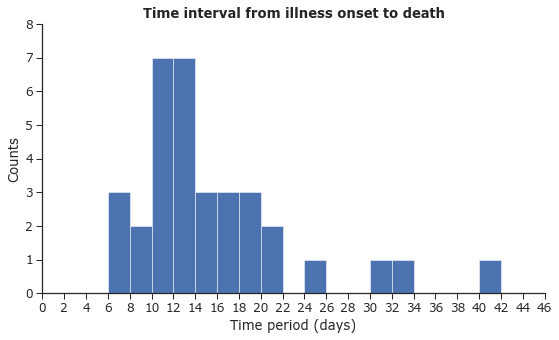

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(9,5.5); 

bins_number = (max(df_onset2death.dist)+2)/2
n, edges = np.histogram(df_onset2death.dist.values, bins=24, range=(0,48), density=False)
timepoints = edges[:-1]
ymax = int(max(n))+1

ax.bar(timepoints, n, lw = 0.5, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge')
xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks])
ax.set_xlabel('Time period (days)'); ax.set_ylabel('Counts'); 
ax.set_title('Time interval from illness onset to death',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

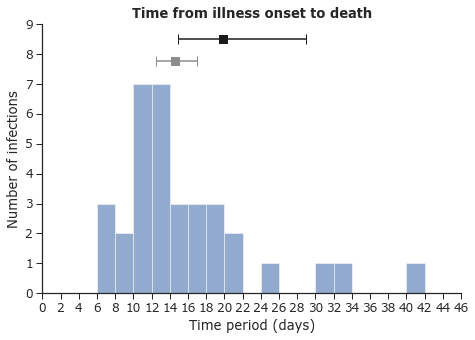

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(7.5,5.5); 

ymax = 9

ax.bar(timepoints, n, lw = 0.8, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge', color='C0', alpha=.6)

# ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,0], res[-1:,0]]*sum(n), color = 'k', zorder=5, where='post')
# ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,1], res[-1:,1]]*sum(n), color = 'k', zorder=5, lw=1, where='post')
# ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,2], res[-1:,2]]*sum(n), color = 'k', zorder=5, lw=1, where='post')
# ax.fill_between(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,1], res[-1:,1]]*sum(n), np.r_[res[:,2], res[-1:,2]]*sum(n), color = 'C7', alpha=.3, zorder=5, step='post')

ax.errorbar([21.95], [8.5], xerr=[7.05], capsize = 5, marker='s', markersize=0, mfc='w', color='k')
ax.scatter([19.9], [8.5], marker='s', s=80, color='k')

ax.errorbar([14.75], [7.75], xerr=[2.25], capsize = 5, marker='s', markersize=0, mfc='w', color='C7')
ax.scatter([14.6], [7.75], marker='s', s=80, color='C7')


xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks])
ax.set_xlabel('Time period (days)'); ax.set_ylabel('Number of infections'); 
ax.set_title('Time from illness onset to death',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

plt.savefig("../../figures/draft/Fig02.pdf",format='pdf',bbox_inches='tight');

In [69]:
 (12.5+17.0)/2

14.75

In [68]:
(12.5-17.0)/2

-2.25

In [10]:
df_onset2report = pd.read_csv("../../data/data_onset2report.csv")
df_onset2report['Onset'] = pd.to_datetime(df_onset2report['Onset'])
df_onset2report

,Onset,distUpper,dist
0,2020-01-03,21,13
1,2020-01-05,19,8
2,2020-01-18,6,2
3,2020-01-15,9,6
4,2020-01-17,7,6
5,2020-01-20,4,3
6,2020-01-14,10,10
7,2020-01-21,3,2
8,2020-01-10,14,14
9,2020-01-21,3,3


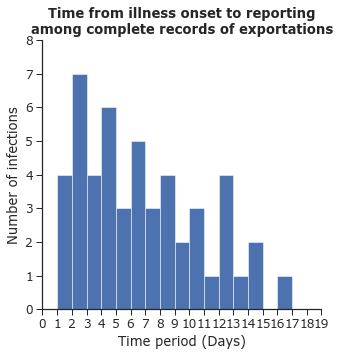

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5.5); 

bins_number = (max(df_onset2report.dist.values)+2)/2
n, edges = np.histogram(df_onset2report.dist.values, bins=20, range=(0,20), density=False)
timepoints = edges[:-1]
ymax = int(max(n))+1

ax.bar(timepoints, n, lw = 0.5, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge')
xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks])
ax.set_xlabel('Time period (Days)'); ax.set_ylabel('Number of infections'); 
ax.set_title('Time from illness onset to reporting\namong complete records of exportations',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [12]:
(LATEST_DATE - df_onset2report['Onset'])/np.timedelta64(1,'D')

0     21.0
1     19.0
2      6.0
3      9.0
4      7.0
5      4.0
6     10.0
7      3.0
8     14.0
9      3.0
10     1.0
11     2.0
12     8.0
13     1.0
14     5.0
15     1.0
16     4.0
17     1.0
18     1.0
19     1.0
20     3.0
21     9.0
22     0.0
23     2.0
24     1.0
25     1.0
26     2.0
27     0.0
28     0.0
29    10.0
30     1.0
31     2.0
32     0.0
33     1.0
34     4.0
35     4.0
36     0.0
37     0.0
38     3.0
39     0.0
40     1.0
41     4.0
42     0.0
43     5.0
44     1.0
45    12.0
46     0.0
47     0.0
48     1.0
49     4.0
50     0.0
Name: Onset, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 150.49:   8%|▊         | 15331/200000 [00:05<01:04, 2868.56it/s]
Convergence achieved at 15500
Interrupted at 15,499 [7%]: Average Loss = 244.78
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [timeOnsetToReport, b_delay, a_delay]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [00:57<00:00, 2603.69draws/s]
/home/aakhmetz/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/aakhmetz/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/aakhmetz/anaconda3/lib/python3.6/site-pack

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_delay,7.070,0.620,5.882,8.300,0.002,0.001,101994.0,100492.0,102889.0,68009.0,1.0
sd_delay,4.403,0.568,3.365,5.533,0.003,0.002,50584.0,50217.0,51734.0,65626.0,1.0


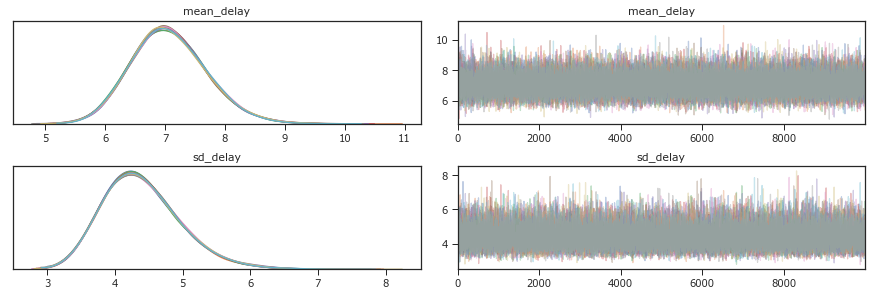

In [14]:
with pm.Model() as model_reporting_delay:
    a_delay = pm.HalfNormal('a_delay', sd=5)
    b_delay = pm.HalfCauchy('b_delay', 2.5)
    
    time_periods = df_onset2report.dist.values
    upper_bound = pm.Data('upper_bound', (LATEST_DATE - df_onset2report['Onset'])/np.timedelta64(1,'D'))
    
    timeOnsetToReport = pm.Uniform('timeOnsetToReport', time_periods, time_periods+1, shape = len(time_periods))
    
    pm.Gamma('likelihood', a_delay, b_delay, shape = len(time_periods), observed=timeOnsetToReport)
    
    pm.Deterministic('mean_delay', a_delay/b_delay);
    pm.Deterministic('sd_delay', np.sqrt(a_delay)/b_delay);
    
    trace = pm.sample(10000, tune=5000, cores=10, target_accept=.9, init='advi')
    
vars_ = ['mean_delay', 'sd_delay']
pm.traceplot(trace, var_names=vars_)
pm.summary(trace, var_names=vars_, credible_interval=.95)

In [15]:
res_delay = pm.summary(trace, var_names=['a_delay', 'b_delay', 'mean_delay'])['mean']
res_delay

a_delay       2.645
b_delay       0.377
mean_delay    7.070
Name: mean, dtype: float64

In [16]:
df_res = az.summary(trace, var_names=['mean_delay', 'sd_delay', 'a_delay', 'b_delay'], stat_funcs=func_dict, extend=False, round_to=5).reset_index().rename(columns={'index': 'var'})
df_res.rename(columns={'q2.5': 'lower', 'q97.5': 'upper'}).loc[:,['var','mean','lower','upper']].to_csv('../../results/onset2report-final.csv', index=False)

In [17]:
bins_number = (max(df_onset2report.dist.values)+2)/2
n, edges = np.histogram(df_onset2report.dist.values, bins=20, range=(0,20), density=False)
timepoints = edges[:-1]
ymax = int(max(n))+1

In [18]:
with model_reporting_delay:
    F = tt.exp(pm.Gamma.dist(a_delay, b_delay).logcdf(edges))
    y = pm.Deterministic('y', F[1:] - F[:-1])
    smpl = pm.sample_posterior_predictive(trace, 100000, var_names=['y'])
    
res = np.c_[np.mean(smpl['y'], axis=0), np.percentile(smpl['y'], 2.5, axis=0), np.percentile(smpl['y'], 97.5, axis=0)]

100%|██████████| 100000/100000 [00:42<00:00, 2367.06it/s]


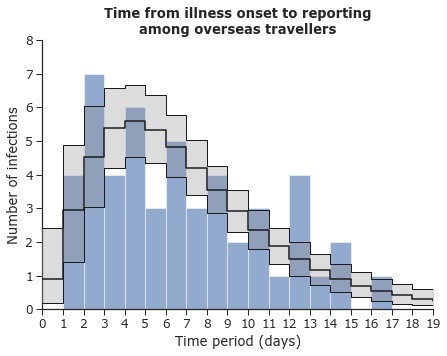

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(7,5.5); 

ax.bar(timepoints, n, lw = 0.8, width = edges[1:]-edges[:-1], edgecolor = 'w', align='edge', color='C0', alpha=.6)

ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,0], res[-1:,0]]*sum(n), color = 'k', zorder=5, where='post')
ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,1], res[-1:,1]]*sum(n), color = 'k', zorder=5, lw=1, where='post')
ax.step(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,2], res[-1:,2]]*sum(n), color = 'k', zorder=5, lw=1, where='post')
ax.fill_between(np.r_[timepoints,timepoints[-1:]], np.r_[res[:,1], res[-1:,1]]*sum(n), np.r_[res[:,2], res[-1:,2]]*sum(n), color = 'C7', alpha=.3, zorder=5, step='post')

xstep = 2
xtks = edges[:-1]
ax.set_xlim(0,max(xtks))
ax.set_ylim(top=ymax)
ax.set_xticks(xtks)
ax.set_xticklabels([int(x) for x in xtks], ha="right")
ax.set_xlabel('Time period (days)'); ax.set_ylabel('Number of infections'); 
ax.set_title('Time from illness onset to reporting\namong overseas travellers',fontweight='bold')
fig.autofmt_xdate(rotation=0,ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

plt.savefig("../../figures/draft/Fig01.pdf",format='pdf',bbox_inches='tight');

# Main module

In [ ]:
start = theano.shared(0.)
stop = theano.shared(250.)
μ = theano.shared(2.838)
σ = theano.shared(0.520)

inci_idx = np.min(df.loc[lambda d: d.exports>0].index)
inci_tmin = df.loc[inci_idx,'time']
len_p = len(df.loc[lambda d: d['time']>=inci_tmin,'prob_travel'])
death_idx = np.min(df.loc[lambda d: d['deaths']>0].index)
with pm.Model() as model:  
    ## main data and priors ##
    K = df['exports'].shape[0]
    exported_cases = df['exports'].values
    p = df.loc[0,'prob_travel']
    
    neglogr = pm.HalfNormal('neglogr', testval=-np.log(0.1))
    r = pm.Deterministic('r',np.exp(-neglogr))
    #T0 = df['time'].values[inci_idx]
    i0 = 1.0
    
    t = tt.arange(1,K+1,1)
    Incidence = pm.Deterministic('Incidence',i0*(tt.exp(r*t)-1.0)/r)
    
    ## implementing numerical integration 
    s = tt.dscalar('s')
    s.tag.test_value = np.zeros(()) #variable of integration
    r_ = tt.dscalar('r_')
    r_.tag.test_value = np.ones(())*0.14
    func = tt.exp(-r_*s)/s/σ/((2.0*np.pi)**0.5)*tt.exp(-((tt.log(s)-μ)**2)/2/(σ**2))
    integrate = Integrate(func, s, r_)
    
    ## calculating us ##
    u_delay = pm.Deterministic('u_delay', (1 + r*res_delay['mean_delay']/res_delay['a_delay'])**(-res_delay['a_delay']))
    u_death = pm.Deterministic('u_death', integrate(start, stop, r))
    ##############################
    
    ## reconstructed incidence from exportation events ##
    mu = (u_delay*Incidence*p/(1-p))[inci_idx:K]
    alpha = (1.0/(1-p))
    pm.Gamma('likelihood_incidence', mu, alpha, shape=K-death_idx, observed=exported_cases[inci_idx:K])
    ##############################
    
    ## CFR ##
    death = df['deaths'].values
    neglogq = pm.Gamma('neglogq', 2, .5, shape=K-death_idx, testval=-np.log(.06))
    q = pm.Deterministic('q',np.exp(-neglogq))
    
    shape_death = u_death*Incidence[death_idx:K]*q/(1-q)
    invscale_death = 1.0/(1-q)
    pm.Gamma('likelihood_death', shape_death, invscale_death, observed=death[death_idx:K])
    ##############################
    
    pm.Deterministic('predictedDeath', u_death*Incidence[death_idx:K]*q)
    
    sample = pm.sample(4000, cores=10, tune=2500, target_accept=.92, init='advi')
    
pm.summary(sample, credible_interval=0.95)

In [ ]:
pm.summary(sample, credible_interval=0.95, var_names=['u_delay', 'u_death', 'r'])

In [ ]:
pm.traceplot(sample, var_names=['r']);

# Saving the results

In [117]:
!mkdir -p ../../results/Scenario-1

In [118]:
df_res = az.summary(sample, var_names=['r','Incidence','q','u_delay','predictedDeath'], stat_funcs=func_dict, extend=False, round_to=6).reset_index().rename(columns={'index': 'var'})
df_res['time'] = df_res['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
df_res['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(df_res['time'],df_res['var'])]
df_res['var'] = df_res['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
df_res.loc[lambda d: d['var']=='q', 'var'] = 'CFR'
df_res.rename(columns={'q2.5': 'lower', 'q97.5': 'upper'}).loc[:,['var','time','mean','lower','upper']].to_csv('../../results/Scenario-1/incidence-final.csv', index=False)

In [119]:
df_res

,var,mean,q2.5,q97.5,time
0,r,0.147104,0.138728,0.154496,NA
1,Incidence,1.077298,1.072686,1.081385,1
2,Incidence,2.325340,2.305000,2.343436,2
3,Incidence,3.771212,3.720696,3.816338,3
4,Incidence,5.446298,5.347063,5.535316,4
...,...,...,...,...,...
76,predictedDeath,7.255537,2.641513,12.696522,12
77,predictedDeath,18.179059,10.478205,26.713933,13
78,predictedDeath,24.156775,15.274476,33.835030,14
79,predictedDeath,34.133468,23.561598,45.580298,15
